### Amazon Review About Products

In [1]:
import tensorflow as tf       
from tensorflow import keras   
import matplotlib.pyplot as plt  
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
import pandas as pd 
import seaborn as sns


In [2]:
amazon=pd.read_csv('train.csv', header=None)
amazon.head()

,0,1,2
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [3]:
# Rename columns based on their meaning
amazon.columns = ["Label", "Title", "Review"]

# Verify
print(amazon.head())


   Label                                              Title  \
0      2                     Stuning even for the non-gamer   
1      2              The best soundtrack ever to anything.   
2      2                                           Amazing!   
3      2                               Excellent Soundtrack   
4      2  Remember, Pull Your Jaw Off The Floor After He...   

                                              Review  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of reviews saying that this ...  
2  This soundtrack is my favorite music of all ti...  
3  I truly like this soundtrack and I enjoy video...  
4  If you've played the game, you know how divine...  


In [4]:
amazon.columns

Index(['Label', 'Title', 'Review'], dtype='object')

In [5]:
amazon.isnull().sum()

Label       0
Title     207
Review      0
dtype: int64

In [6]:
amazon.shape

(3600000, 3)

In [7]:
amazon.isnull().sum()

Label       0
Title     207
Review      0
dtype: int64

In [8]:
# Fill only missing values in the 'Title' column
amazon["Title"] = amazon["Title"].fillna("No title provided")
amazon.isnull().sum()

Label     0
Title     0
Review    0
dtype: int64

In [9]:
# Convert labels: 2 → 1 (positive), 1 → 0 (negative)
amazon["Label"] = amazon["Label"].map({1: 0, 2: 1})


In [10]:
amazon["Label"].value_counts()


Label
1    1800000
0    1800000
Name: count, dtype: int64

In [11]:
amazon["Text"] = amazon["Title"] + " " + amazon["Review"]


In [12]:
import re

def clean_text(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

amazon["Text"] = amazon["Text"].apply(clean_text)


In [13]:
amazon.head()

,Label,Title,Review,Text
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,stuning even for the nongamer this sound track...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,the best soundtrack ever to anything im readin...
2,1,Amazing!,This soundtrack is my favorite music of all ti...,amazing this soundtrack is my favorite music o...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,excellent soundtrack i truly like this soundtr...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",remember pull your jaw off the floor after hea...


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Take a sample of 50,000 rows (adjust based on your RAM)
amazon_sample = amazon.sample(n=50000, random_state=42)

#  Step 1: Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(amazon_sample["Text"])

#  Step 2: Tokenize and pad
sequences = tokenizer.texts_to_sequences(amazon_sample["Text"])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

#  Step 3: Inputs and labels
X = padded_sequences
y = amazon_sample["Label"].values

#  Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Step 5: Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))  # Match tokenizer num_words
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Build the model to fix the '?' in summary
model.build(input_shape=(None, 100))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Show model summary
model.summary()



c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Add early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',        # Watch validation loss
    patience=2,                # Stop if no improvement after 2 epochs
    restore_best_weights=True # Restore the best model weights
)


In [ ]:

#  Step 6: Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.5328 - loss: 0.6864 - val_accuracy: 0.5286 - val_loss: 0.6911
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - accuracy: 0.5166 - loss: 0.6921 - val_accuracy: 0.5361 - val_loss: 0.6861
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 339ms/step - accuracy: 0.6885 - loss: 0.6034 - val_accuracy: 0.7559 - val_loss: 0.5570
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.7512 - loss: 0.5548 - val_accuracy: 0.7096 - val_loss: 0.5748
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - accuracy: 0.7370 - loss: 0.5471 - val_accuracy: 0.7624 - val_loss: 0.5294
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.7389 - loss: 0.5597 - val_accuracy: 0.7779 - val_loss: 0.5126
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.7817 - loss: 0.5002 - val_accuracy: 0.7885 - val_loss: 0.4988
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.8168 - loss: 0.4

In [17]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8528 - loss: 0.3570
Test Accuracy: 0.8542


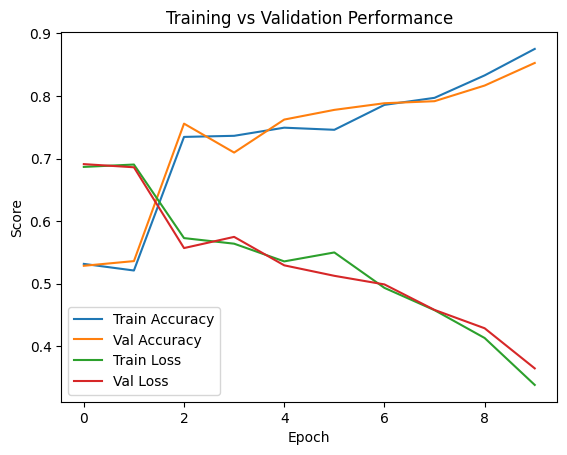

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Performance")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()


In [19]:
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_labels))


              precision    recall  f1-score   support

           0       0.89      0.81      0.85      5001
           1       0.82      0.90      0.86      4999

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



In [22]:
# Function to make predictions on custom input
def predict_sentiment(text):
    # Combine as single-element list
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=100, padding='post', truncating='post')
    
    # Predict
    pred = model.predict(padded)[0][0]
    label = "Positive" if pred > 0.5 else "Negative"
    
    print(f"\nReview: {text}")
    print(f" Prediction: {label} (Confidence: {pred:.4f})")

# Example usage
predict_sentiment("This product is amazing and I really loved using it every day!")
predict_sentiment("Worst experience ever. Totally disappointed and wasted my money.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Review: This product is amazing and I really loved using it every day!
 Prediction: Positive (Confidence: 0.9328)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Review: Worst experience ever. Totally disappointed and wasted my money.
 Prediction: Negative (Confidence: 0.0215)
